In [ ]:
# Clustering
# Code by Pascal Wallisch and Stephen Spivack
# Date: 12-05-21

In [ ]:
# Machine learning methods are all the rage because they allow us to
# automate otherwise cognitive tasks. For instance, spam detection, virus
# detection, making a self-driving car, robots, etc. 
# We could call it "AI". It is driven by "big data" to work properly.

# For this, we'll use a toy example. Imagine you work for the wellness exchange
# at NYU. You want to predict who will get depressed in college. 
# So we can allocate resources to improve academic success rates.
# To make such a prediction, we have to use relevant (!) data and use ML
# methods to discern patterns - relationships in the data. Then apply it to
# a new set of data. 

# In this lab - part 1 - we will focus on clustering. Next time, we will
# further explore these data using classification models.

In [1]:
# 0. Init
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.cluster import DBSCAN

In [2]:
# 1. Loader
students = pd.read_csv('studentHealthData.csv')

In [ ]:
# 2. Exploring data frames

# We know about matrices and arrays. Those work fine, but imagine we have a matrix 
# with 100 columns that represent the variables. 

# Immediate question: What does each column represent? That's where data frames come in.

# The data frame "students" is an object. It has fields and each field for
# each member of the data frame has a value

print(students.loc[21]) # Outputs entire row
students.age.loc[1713] # Just the value of that field
ages = students.age # This is a series
ages = ages.to_numpy() # Convert to array

# Coding principle: Organisms store information with DNA. But organisms
# compute with RNA - that's what makes the actual proteins.
# Strong advice: STORE your data in data frames, as they will be inherently labeled. 
# But do your computations with arrays. That's at least what we do.

In [3]:
# 3. Extract what we need from the students structure to do the job
# We're going to extract 6 predictors and 1 outcome
# For the time being, we won't extract gender because it is categorical. It
# can be used, but it complicates thing. 
# We also don't extract age because we will have a restricted age problem. 
# In general, ML methods are not magic. If the data going in has
# limitations, ML won't be able to rescue you. If the data is problematic,
# ML methods could make the situation worse. 

yOutcomes = students.depression.to_numpy()
predictors = students[["friends","fbfriends","extraversion",
                       "neuroticism","stress","cortisol"]].to_numpy()

# If this was the 20th century, we would now do classical statistics.
# Null hypothesis significance testing. But: What will that tell you you?
# You could test 6 relationships here. Say we find that mean number of
# friends is significantly different between people with or without
# depression.

# This approach can still be meaningfully done, but it tells us about the
# population, i.e. the relationship between the constructs, i.e. between
# friendship and depression.

# What do we want to know? Our question is different. Of these specific 
# students, who is likely to become depressed?
# Related: We want to use all predictors at once, for a given individual

# Taking a closer look: Are the predictors uncorrelated?
# By common sense, these variables are very unlikely to be independent

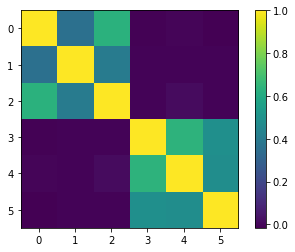

In [4]:
# 4. To ascertain whether a PCA is indicated, let's look at the correlation heatmap
r = np.corrcoef(predictors,rowvar=False)
plt.imshow(r) 
plt.colorbar()
plt.show()

# The variables are not uncorrelated. There is a correlation structure
# The correlation structure suggests that there will be 2 meaningful.
# factors. 1-3 are correlated (1 cluster) and 4-6 are correlated (2nd
# cluster), but they are not correlated between clusters.
# The intercorrelations in one cluster are slightly higher than in
# another, so we predict that eigenvalues in 1 are going to be slightly
# higher.

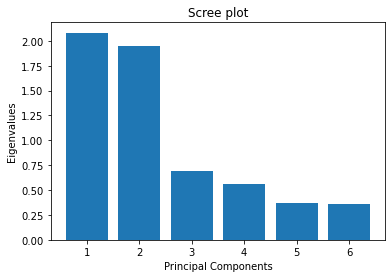

In [5]:
# 5. PCA is indicated, and we have an expectation of the results. So let's do a PCA.

# Z-score the data:
zscoredData = stats.zscore(predictors)

# Initialize PCA object and fit to our data:
pca = PCA().fit(zscoredData)

# Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
eigVals = pca.explained_variance_

# Loadings (eigenvectors): Weights per factor in terms of the original data.
loadings = pca.components_*-1

# Rotated Data - simply the transformed data:
origDataNewCoordinates = pca.fit_transform(zscoredData)*-1

# Scree plot:
numPredictors = 6
plt.bar(np.linspace(1,numPredictors,numPredictors),eigVals)
plt.title('Scree plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()

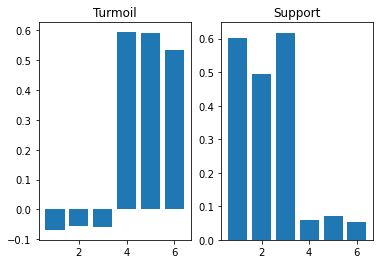

In [6]:
# Looking at the corrected scree plot, we get 2 factors, both by 
# Kaiser criterion and Elbow.

# Next step: Look at the loadings to figure out meaning:
plt.subplot(1,2,1) # Factor 1: 
plt.bar(np.linspace(1,numPredictors,numPredictors),loadings[0,:]) # "Turmoil"
plt.title('Turmoil')
plt.subplot(1,2,2) # Factor 2:
plt.bar(np.linspace(1,numPredictors,numPredictors),loadings[1,:]) # "Support"
plt.title('Support')
plt.show()

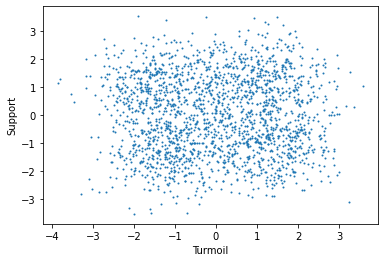

In [7]:
# 6. Visualize our data in the new coordinate system:
plt.plot(origDataNewCoordinates[:,0],origDataNewCoordinates[:,1],'o',markersize=1)
plt.xlabel('Turmoil')
plt.ylabel('Support')
plt.show()

In [8]:
# 7. Clustering - doing quantitatively what can be seen intuitively

# Clustering answers - in a data-driven way - which subgroup a datapoint belongs to.
# The "kMeans clustering" is like pca of clustering. It's not the only clustering 
# method, but it is the most commonly used one.

# Algorithm: Minimize the summed distances between a cluster center and its
# members. Once the minimum has been found (regardless of starting
# position), it stops. "Converging".

# Store our transformed data - the predictors - as x:
x = np.column_stack((origDataNewCoordinates[:,0],origDataNewCoordinates[:,1]))

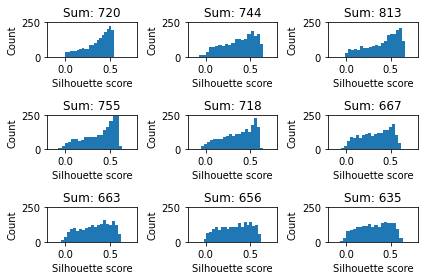

In [9]:
# Silhouette: How similar to points in cluster vs. others, arbitrariness

# Remember: each data point gets its own silhouette coefficient ranging 
# from 0 (arbitrary classification) to 1 (ideal classification).

# Init:
numClusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([numClusters,1])*np.NaN # init container to store sums

# Compute kMeans:
for ii in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(ii)).fit(x) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(x,cId) # compute the mean silhouette coefficient of all samples
    Q[ii-2] = sum(s) # take the sum
    # Plot data:
    plt.subplot(3,3,ii-1) 
    plt.hist(s,bins=20) 
    plt.xlim(-0.2,0.8)
    plt.ylim(0,250)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title('Sum: {}'.format(int(Q[ii-2]))) # sum rounded to nearest integer
    plt.tight_layout() # adjusts subplot padding

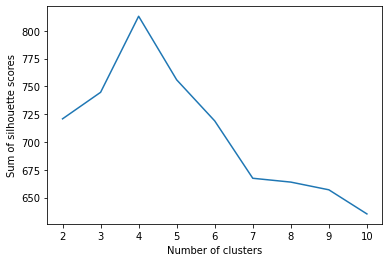

In [10]:
# Plot this to make it clearer what is going on
plt.plot(np.linspace(2,10,numClusters),Q)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

# kMeans gives you the center coordinates of the clusters, assuming a number
# of clusters. Silhouette gives you how many are most unamigously described
# by the clusters. Most likely "real" number: Where the sum of the
# silhouette scores peaks. In reality, they are complementary. Use together

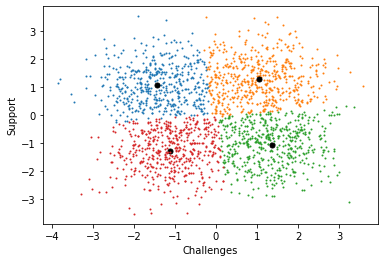

In [11]:
# Now let's recompute the kMeans using 4 clusters and plot the color-coded data

# Recompute kMeans:
numClusters = 4
kMeans = KMeans(n_clusters = numClusters).fit(x) 
cId = kMeans.labels_ 
cCoords = kMeans.cluster_centers_ 

# Plot the color-coded data:
for ii in range(numClusters):
    plotIndex = np.argwhere(cId == int(ii))
    plt.plot(x[plotIndex,0],x[plotIndex,1],'o',markersize=1)
    plt.plot(cCoords[int(ii-1),0],cCoords[int(ii-1),1],'o',markersize=5,color='black')  
    plt.xlabel('Challenges')
    plt.ylabel('Support')
    
# As you can see, kMeans returns as many clusters as you ask for. 
# What it does is returns the optimal center that minimizes the summed
# distance from all centers. But it requires - as an input (!) - how many
# clusters to look for. Basically, you find what you look for in terms of
# cluster number. And the sum of the summed distances is only going down

# Solution: "Silhouette"
# Silhouette takes distances nearest neighbor clusters into account

In [12]:
# Now let's move on to a different example. Here, we want to cluster the stars of
# a spiral galaxy, as seen in lecture. Enter the DBSCAN clustering algorithm.

# Load the data:
data = np.genfromtxt('spiralGalaxyData.csv', delimiter=',')
print(data[:10])

# Here, the first column is our x-coordinate, the second column is our y-coordinate,
# and the third column is which spiral it belongs to (0 or 1). For now, since we 
# are doing unsupervised learning, we will pretend we do not have the labels. Instead,
# we will use DBSCAN to find them.

[[10.243    1.3698   0.     ]
 [ 9.8072  -3.4605   0.     ]
 [ 3.2632  -2.2552   0.     ]
 [ 9.2711  -4.0075   0.     ]
 [ 4.5864   8.2675   0.     ]
 [ 3.1592  -1.4759   0.     ]
 [-3.8878  -1.8923   0.     ]
 [ 0.87769  8.0552   0.     ]
 [ 8.6303  -6.2331   0.     ]
 [ 8.6697  -5.9389   0.     ]]


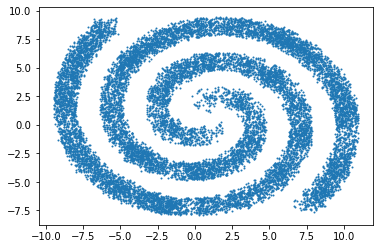

In [13]:
# Let's plot our data to see what they look like
plt.plot(data[:,0],data[:,1],'o',markersize=1)
plt.show()

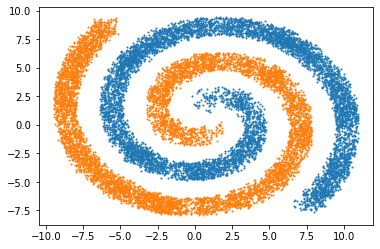

In [14]:
# Run the DBSCAN and plot the color-coded data

# Format data:
x = np.column_stack((data[:,0],data[:,1]))

# Fit model to our data:
dbscanModel = DBSCAN().fit(x) # Default eps = 0.5, min_samples = 5

# Get our labels for each data point:
labels = dbscanModel.labels_

# Plot the color-coded data:
numSpirals = 2
for ii in range(numSpirals):
    labelIndex = np.argwhere(labels==ii)
    plt.plot(data[labelIndex,0],data[labelIndex,1],'o',markersize=1)